In [ ]:
import gc_utils
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from sklearn.svm import SVC

In [2]:
simulation = "m12i"
sim_dir = "/Users/z5114326/Documents/simulations/"

proc_file = sim_dir + simulation + "/" + simulation + "_processed.hdf5"
proc_data = h5py.File(proc_file, "r")  # open processed data file

In [3]:
snap_pub_dir = sim_dir + "/snapshot_times_public.txt"
snap_pub_data = pd.read_table(snap_pub_dir, comment="#", header=None, sep=r"\s+")
snap_pub_data.columns = [
    "index",
    "scale_factor",
    "redshift",
    "time_Gyr",
    "lookback_time_Gyr",
    "time_width_Myr",
]

In [ ]:
it = 0
snap = 294

it_id = gc_utils.iteration_name(it)
snap_id = gc_utils.snapshot_name(snap)

props = ["inc", "lz_norm", "r", "form_time", "ecc", "logm_tform"]
prop_locs = ["snap", "snap", "snap", "sour", "snap", "sour"]
prop_scale = ["linear", "linear", "log", "linear", "linear", "linear"]

prop_dict = {"in_situ_s": {}, "in_situ_d": {}, "ex_situ_s": {}, "ex_situ_d": {}}

sour_dat = proc_data[it_id]["source"]
ana_mask = sour_dat["analyse_flag"][()] == 1

src_gc_ids = sour_dat["gc_id"][ana_mask]
src_grp_ids = sour_dat["group_id"][ana_mask]
src_tdis_s = sour_dat["t_dis"][ana_mask]

snap_dat = proc_data[it_id]["snapshots"][snap_id]
acc_mask = snap_dat["now_accreted"][()] == 1
snp_gc_ids = snap_dat["gc_id"][acc_mask]

is_lst = []
id_lst = []
es_lst = []
ed_lst = []

for gcid in snp_gc_ids:
    gc_idx = np.where(src_gc_ids == gcid)[0][0]
    grp = src_grp_ids[gc_idx]
    tdis = src_tdis_s[gc_idx]

    if (grp == 0) & (tdis < 0):
        is_lst.append(gcid)

    elif (grp == 0) & (tdis > 0):
        id_lst.append(gcid)

    elif (grp != 0) & (tdis < 0):
        es_lst.append(gcid)

    elif (grp != 0) & (tdis > 0):
        ed_lst.append(gcid)


prop_dict["in_situ_s"]["gcid"] = np.array(is_lst)
prop_dict["in_situ_d"]["gcid"] = np.array(id_lst)
prop_dict["ex_situ_s"]["gcid"] = np.array(es_lst)
prop_dict["ex_situ_d"]["gcid"] = np.array(ed_lst)

for gc_type in prop_dict.keys():
    for prop, prop_loc in zip(props, prop_locs):
        prop_lst = []
        if prop_loc == "sour":
            for gcid in prop_dict[gc_type]["gcid"]:
                gcid_idx = np.where(sour_dat["gc_id"][ana_mask] == gcid)[0][0]
                prop_lst.append(sour_dat[prop][ana_mask][gcid_idx])

        else:
            for gcid in prop_dict[gc_type]["gcid"]:
                gcid_idx = np.where(snap_dat["gc_id"] == gcid)[0][0]
                prop_lst.append(snap_dat[prop][gcid_idx])

        prop_dict[gc_type][prop] = np.array(prop_lst)

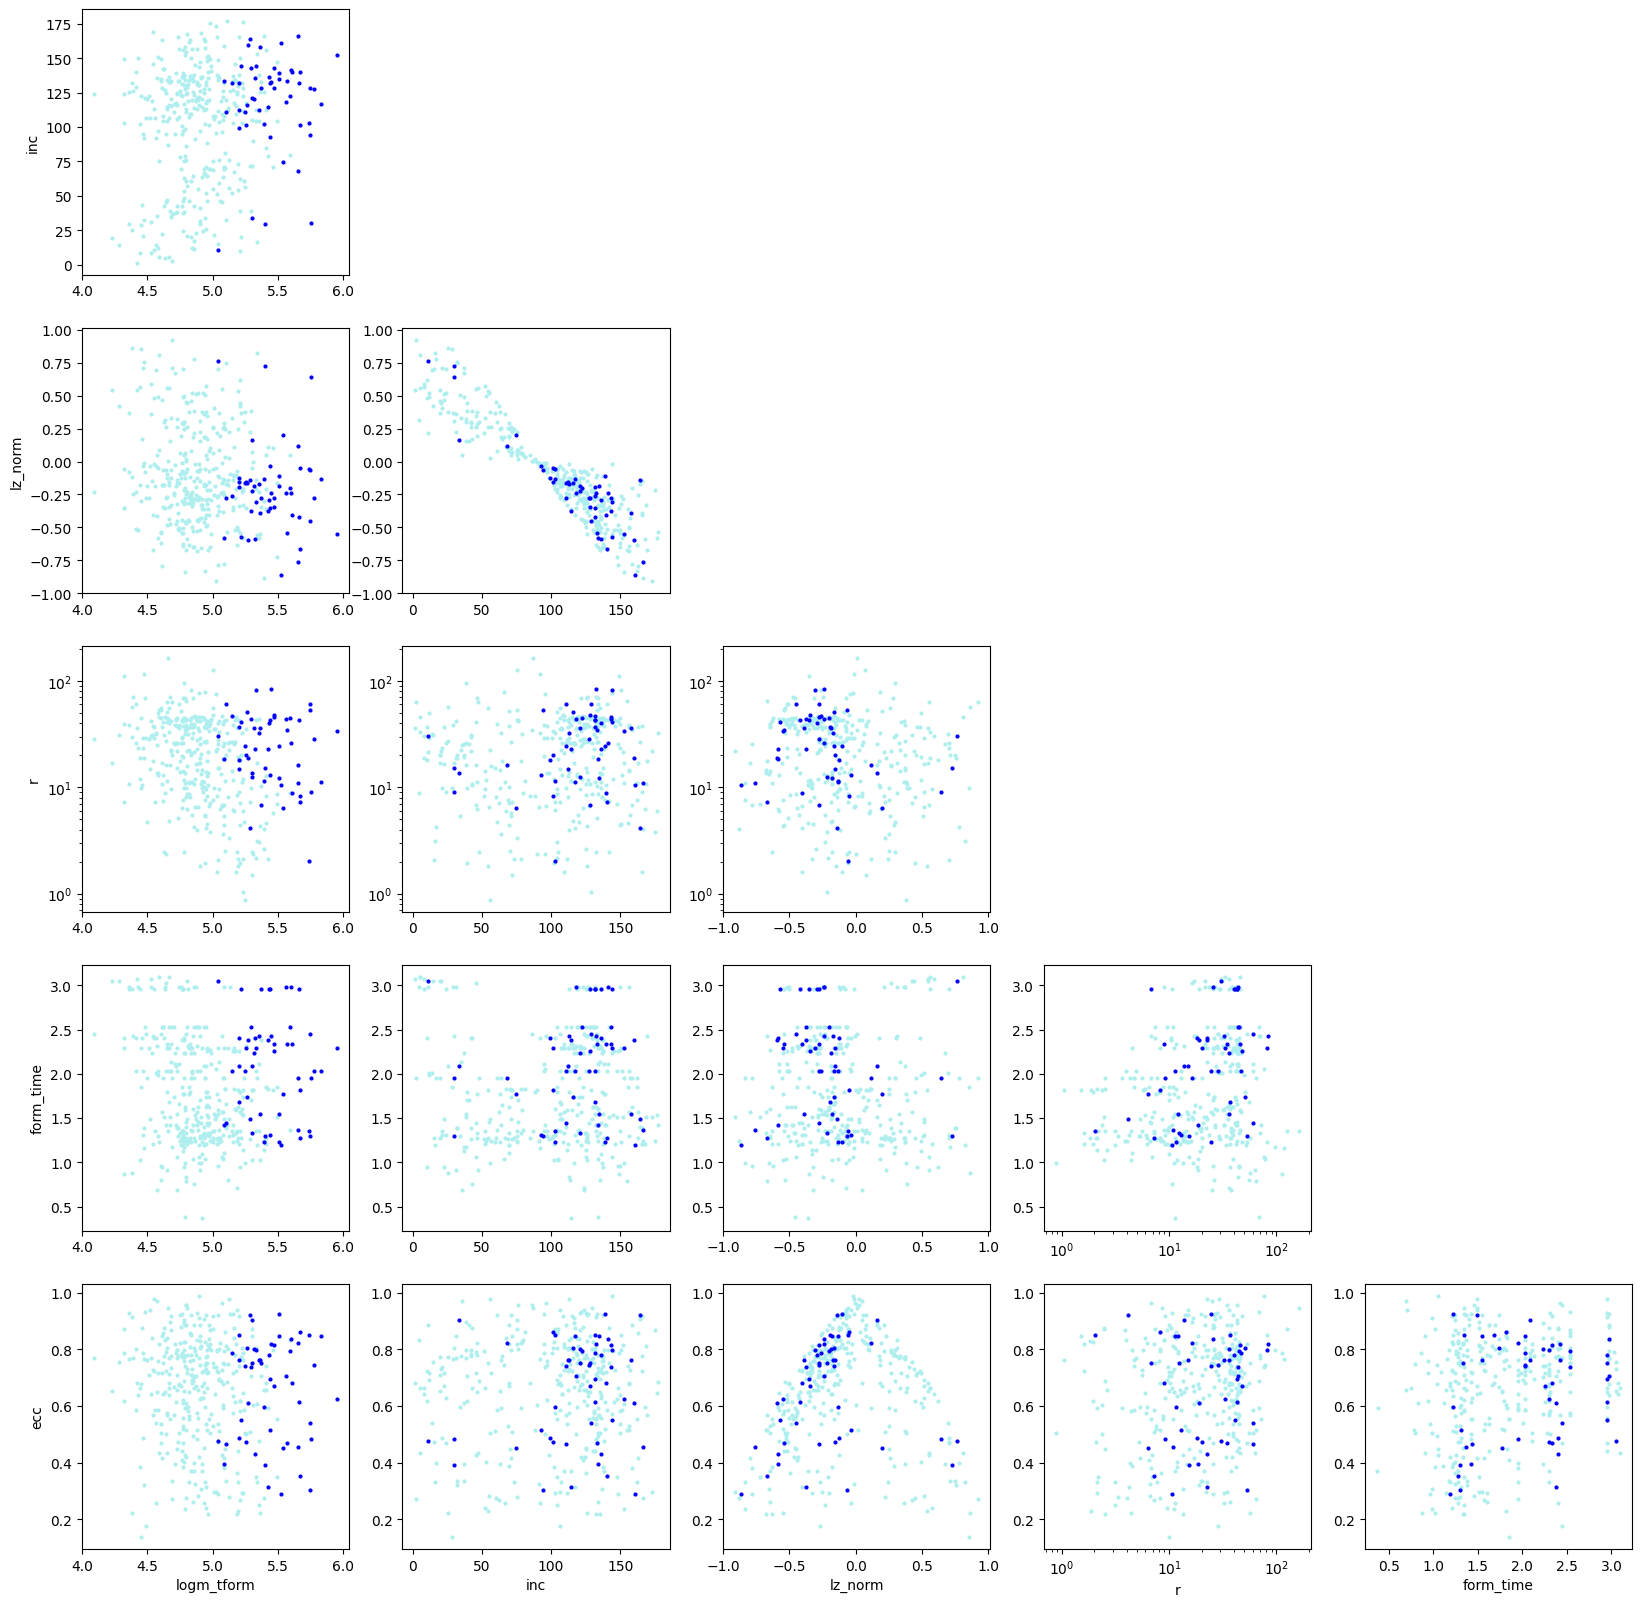

In [5]:
num_rows = len(props) - 1
num_cols = len(props) - 1

type_check = ["in_situ_s", "in_situ_d", "ex_situ_s", "ex_situ_d"]
type_check = ["in_situ_s", "in_situ_d"]
type_check = ["ex_situ_s", "ex_situ_d"]

plot_c = ["r", "pink", "blue", "paleturquoise"]
plot_m = [".", ".", ".", "."]
plot_s = [4, 4, 4, 4]
plot_z = [1, 0, 1, 0]

fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# for i, ax in enumerate(axs.flat):
for (i, j), ax in np.ndenumerate(axs):
    if j > i:
        ax.axis("off")

    else:
        prop_x = props[j - 1]
        x_scale = prop_scale[j - 1]

        prop_y = props[i]
        y_scale = prop_scale[i]

        for type_i, gc_type in enumerate(prop_dict.keys()):
            if gc_type in type_check:
                xd = prop_dict[gc_type][prop_x]
                yd = prop_dict[gc_type][prop_y]

                ax.scatter(xd, yd, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
                ax.set_xscale(x_scale)
                ax.set_yscale(y_scale)

        if i == num_rows - 1:
            ax.set_xlabel(prop_x)

        if j == 0:
            ax.set_ylabel(prop_y)


In [6]:
for gc_type in prop_dict.keys():
    pos_lst = []
    for gcid in prop_dict[gc_type]["gcid"]:
        gcid_idx = np.where(snap_dat["gc_id"] == gcid)[0][0]
        pos_lst.append(snap_dat["pos.xyz"][gcid_idx])

    prop_dict[gc_type]["pos.xyz"] = np.array(pos_lst)

Text(0, 0.5, 'y [kpc]')

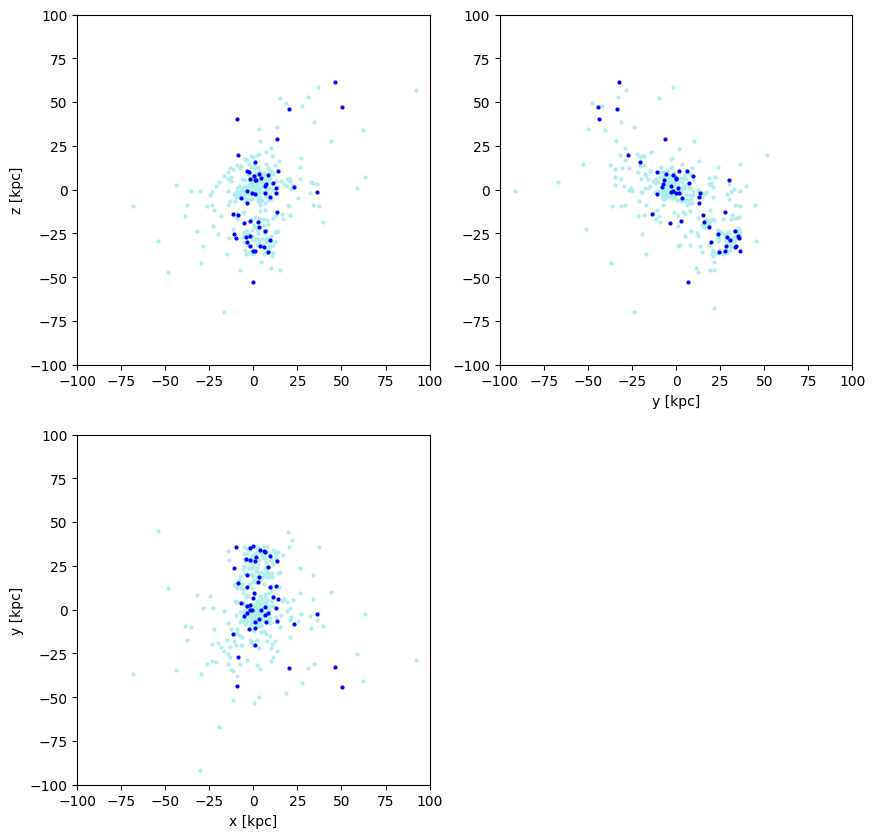

In [7]:
type_check = ["in_situ_s", "in_situ_d", "ex_situ_s", "ex_situ_d"]
type_check = ["in_situ_s", "in_situ_d"]
type_check = ["ex_situ_s", "ex_situ_d"]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

for type_i, gc_type in enumerate(prop_dict.keys()):
    if gc_type in type_check:
        pos_xyz = prop_dict[gc_type]["pos.xyz"]
        xd = pos_xyz[:, 0]
        yd = pos_xyz[:, 1]
        z = pos_xyz[:, 2]

        axs[0, 0].scatter(xd, z, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
        axs[0, 1].scatter(yd, z, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])
        axs[1, 0].scatter(xd, yd, s=plot_s[type_i], c=plot_c[type_i], zorder=plot_z[type_i])

for ax in axs.flat:
    ax.set_xlim([-100, 100])
    ax.set_ylim([-100, 100])

axs[1, 1].axis("off")

axs[0, 1].set_xlabel("y [kpc]")
axs[1, 0].set_xlabel("x [kpc]")

axs[0, 0].set_ylabel("z [kpc]")
axs[1, 0].set_ylabel("y [kpc]")

In [8]:
for gc_type in prop_dict.keys():
    tdis_lst = []
    tfor_lst = []
    for gcid in prop_dict[gc_type]["gcid"]:
        gcid_idx = np.where(sour_dat["gc_id"][ana_mask] == gcid)[0][0]
        tdis_lst.append(sour_dat["t_dis"][ana_mask][gcid_idx])
        tfor_lst.append(sour_dat["form_time"][ana_mask][gcid_idx])

    prop_dict[gc_type]["t_dis"] = np.array(tdis_lst)
    prop_dict[gc_type]["form_time"] = np.array(tfor_lst)

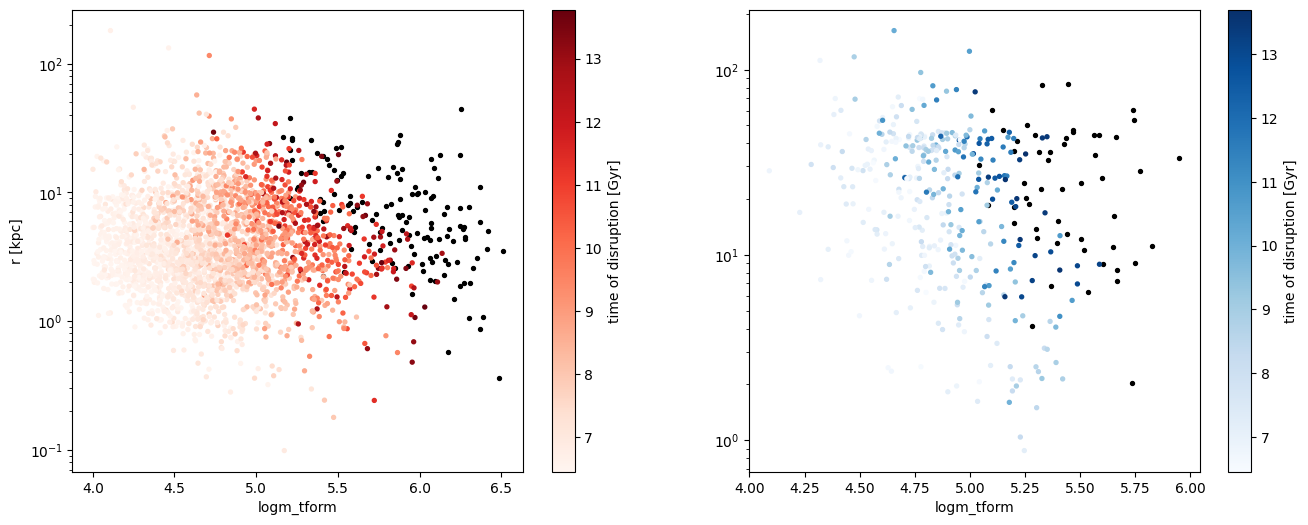

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(wspace=0.2, hspace=0.2)

sd = [None, None]
for type_i, gc_type in enumerate(prop_dict.keys()):
    if "in" in gc_type:
        i = 0
        cmap = "Reds"
    else:
        i = 1
        cmap = "Blues"

    tdis_mask = prop_dict[gc_type]["t_dis"] > 0

    xd = prop_dict[gc_type]["logm_tform"][tdis_mask]
    yd = prop_dict[gc_type]["r"][tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][tdis_mask]

    sd[i] = axs[i].scatter(xd, yd, c=cd, cmap=cmap, s=8)

    xd = prop_dict[gc_type]["logm_tform"][~tdis_mask]
    yd = prop_dict[gc_type]["r"][~tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][~tdis_mask]

    axs[i].scatter(xd, yd, s=8, c="k")

for i in [0, 1]:
    if sd[i] is not None:
        fig.colorbar(sd[i], ax=axs[i], label="time of disruption [Gyr]")

axs[0].set_xlabel("logm_tform")
axs[1].set_xlabel("logm_tform")

axs[0].set_ylabel("r [kpc]")

axs[0].set_yscale("log")
axs[1].set_yscale("log")

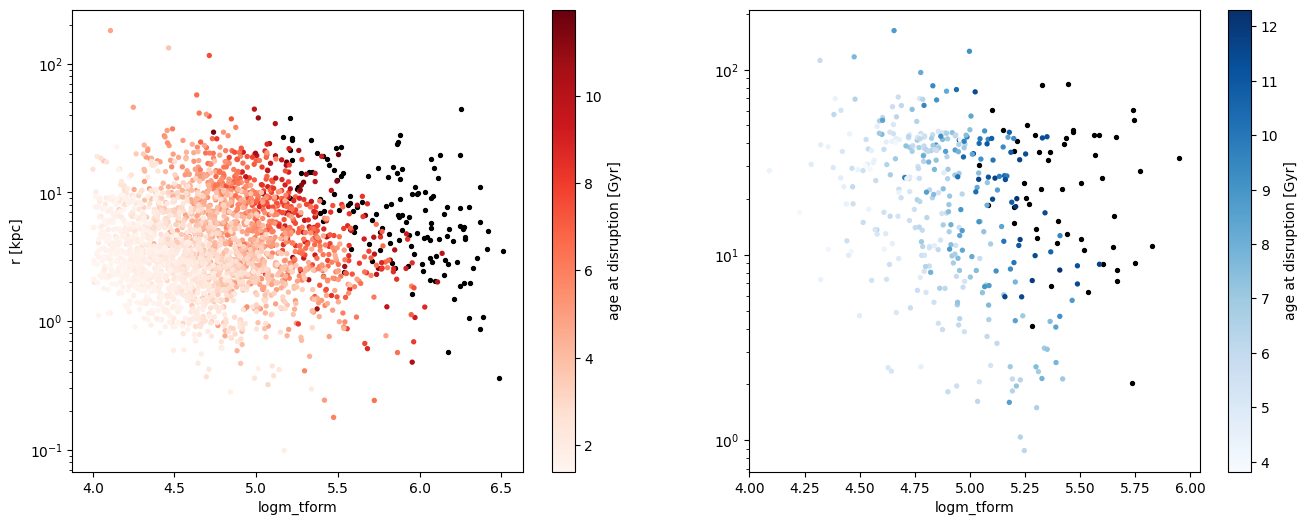

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
# plt.subplots_adjust(wspace=0.2, hspace=0.2)

sd = [None, None]
for type_i, gc_type in enumerate(prop_dict.keys()):
    if "in" in gc_type:
        i = 0
        cmap = "Reds"
    else:
        i = 1
        cmap = "Blues"

    tdis_mask = prop_dict[gc_type]["t_dis"] > 0

    xd = prop_dict[gc_type]["logm_tform"][tdis_mask]
    yd = prop_dict[gc_type]["r"][tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][tdis_mask] - prop_dict[gc_type]["form_time"][tdis_mask]

    sd[i] = axs[i].scatter(xd, yd, c=cd, cmap=cmap, s=8)

    xd = prop_dict[gc_type]["logm_tform"][~tdis_mask]
    yd = prop_dict[gc_type]["r"][~tdis_mask]
    cd = prop_dict[gc_type]["t_dis"][~tdis_mask] - prop_dict[gc_type]["form_time"][~tdis_mask]

    axs[i].scatter(xd, yd, s=8, c="k")

for i in [0, 1]:
    if sd[i] is not None:
        fig.colorbar(sd[i], ax=axs[i], label="age at disruption [Gyr]")

axs[0].set_xlabel("logm_tform")
axs[1].set_xlabel("logm_tform")

axs[0].set_ylabel("r [kpc]")

axs[0].set_yscale("log")
axs[1].set_yscale("log")

In [11]:
prop_dict["in_situ_s"].keys()

dict_keys(['gcid', 'inc', 'lz_norm', 'r', 'form_time', 'ecc', 'logm_tform', 'pos.xyz', 't_dis'])

In [12]:
def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})", cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

In [13]:
prop_dict["in_situ_s"].keys()

dict_keys(['gcid', 'inc', 'lz_norm', 'r', 'form_time', 'ecc', 'logm_tform', 'pos.xyz', 't_dis'])

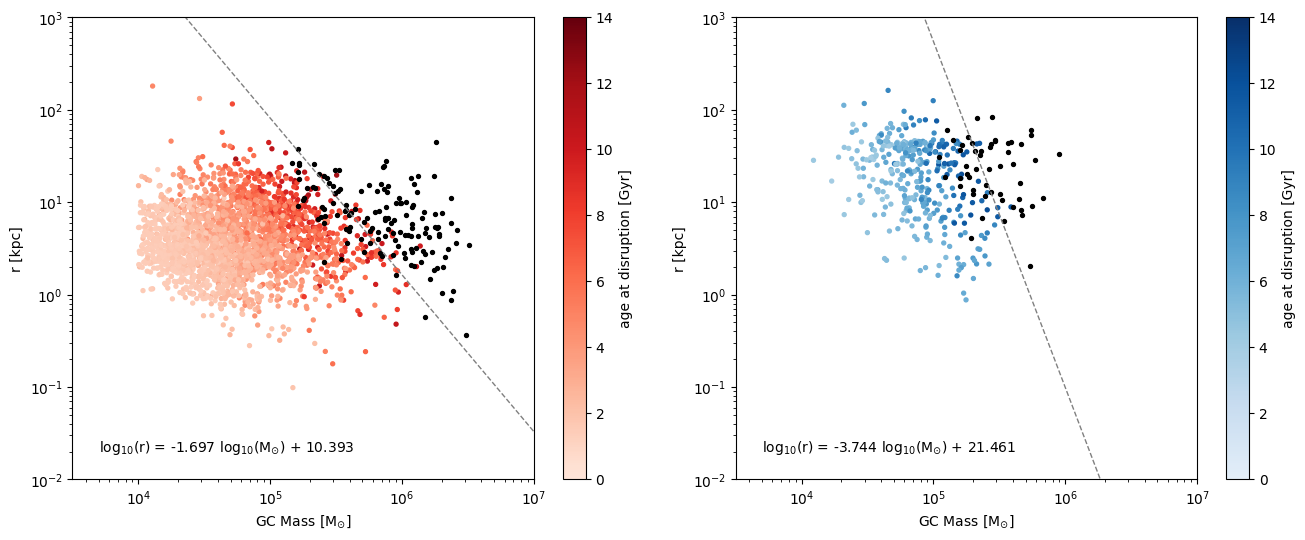

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.15, hspace=0)

sd = [None, None]
full_type = ["in_situ", "ex_situ"]
line = []
for type_i, gc_type in enumerate(full_type):
    if "in" in gc_type:
        i = 0
        cmap = truncate_colormap(plt.get_cmap("Reds"), 0.1, 1.0)
    else:
        i = 1
        cmap = truncate_colormap(plt.get_cmap("Blues"), 0.1, 1.0)

    alive = gc_type + "_s"
    dead = gc_type + "_d"

    s_m = 10 ** prop_dict[alive]["logm_tform"]
    s_r = prop_dict[alive]["r"]

    d_m = 10 ** prop_dict[dead]["logm_tform"]
    d_r = prop_dict[dead]["r"]
    d_c = np.array(prop_dict[dead]["t_dis"]) - np.array(prop_dict[dead]["form_time"])

    X_s_fit = np.stack((np.log10(s_m), np.log10(s_r)), axis=1)
    X_d_fit = np.stack((np.log10(d_m), np.log10(d_r)), axis=1)

    # X_s_plot = np.stack((s_m, s_r), axis=1)
    # X_d_plot = np.stack((d_m, d_r), axis=1)

    X_fit = np.vstack((X_s_fit, X_d_fit))
    # X_plot = np.vstack((X_s_plot, X_d_plot))

    y = np.array([0] * len(X_s_fit) + [1] * len(X_d_fit))

    # Fit linear SVM
    clf = SVC(kernel="linear")
    clf.fit(X_fit, y)

    # Get decision boundary parameters
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # Create decision boundary line
    x_vals = np.linspace(3.5, 7, 100)
    y_vals = -(w[0] * x_vals + b) / w[1]
    axs[i].plot(10**x_vals, 10**y_vals, "grey", ls="--", lw=1)

    m = np.round(-w[0] / w[1], 3)
    c = np.round(-b / w[1], 3)

    if c < 0:
        sign = "-"
    else:
        sign = "+"

    line_text = r"log$_{10}$(r) = " + str(m) + r" log$_{10}$(M$_{\odot}$) " + sign + " " + str(np.abs(c))
    line.append(line_text)

    sd[i] = axs[i].scatter(d_m, d_r, c=d_c, cmap=cmap, s=8, vmin=0, vmax=14)
    axs[i].scatter(s_m, s_r, s=8, c="k")

for i in [0, 1]:
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")

    axs[i].set_xlim([10**3.5, 10**7])
    axs[i].set_ylim([10**-2, 10**3])

    axs[i].set_xlabel(r"GC Mass [M$_{\odot}$]")
    axs[i].set_ylabel("r [kpc]")

    axs[i].text(0.5 * 10**4, 0.2 * 10**-1, line[i], fontsize=10, ha="left")

    if sd[i] is not None:
        fig.colorbar(sd[i], ax=axs[i], label="age at disruption [Gyr]")


Text(0, 0.5, 'Mass at z=0 (M$_\\odot$)')

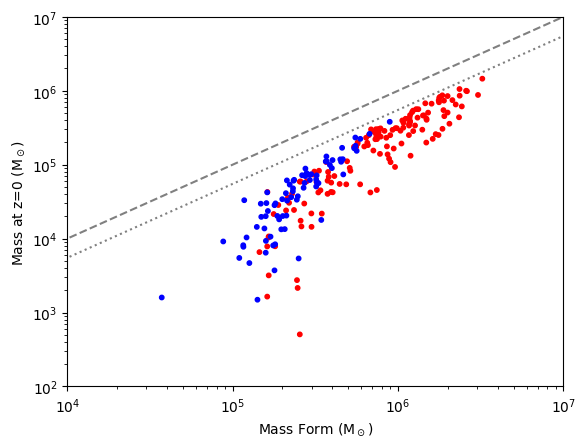

In [28]:
mass_z0 = 10 ** proc_data["it000"]["snapshots"]["snap600"]["mass"][()]
gc_ids = proc_data["it000"]["snapshots"]["snap600"]["gc_id"][()]

ana_msk = proc_data["it000"]["source"]["analyse_flag"][()] == 1

mass_form = []
for gc in gc_ids:
    idx = np.where(proc_data["it000"]["source"]["gc_id"][ana_mask] == gc)[0][0]
    mass_form.append(proc_data["it000"]["source"]["logm_tform"][ana_mask][idx])

c = []
for grp in proc_data["it000"]["snapshots"]["snap600"]["group_id"][()]:
    grp = np.abs(grp)
    if grp == 0:
        c.append("red")
    else:
        c.append("blue")

mass_form = 10 ** np.array(mass_form)

plt.scatter(mass_form, mass_z0, c=c, s=10)
plt.plot([10**2, 10**7], [10**2, 10**7], c="grey", ls="--")
plt.plot([10**2, 10**7], 0.55 * np.array([10**2, 10**7]), c="grey", ls="dotted")

plt.xlim(10**4, 10**7)
plt.ylim(10**2, 10**7)

plt.xscale("log")
plt.yscale("log")

plt.xlabel(r"Mass Form (M$_\odot$)")
plt.ylabel(r"Mass at z=0 (M$_\odot$)")

In [16]:
# proc_data.close()